Uniform Original Size: 400000 bytes
Uniform Compressed Size: 400000 bytes
Gaussian Original Size: 400000 bytes
Gaussian Compressed Size: 400000 bytes
Exponential Original Size: 400000 bytes
Exponential Compressed Size: 400000 bytes

Statistics for Uniform:
Original Mean: -0.2995097309161197, Compressed Mean: -0.29949785519212485
Original Variance: 3348.3534976553046, Compressed Variance: 3348.353210552821
Original Std Dev: 57.864959151936716, Compressed Std Dev: 57.86495667113923

Statistics for Gaussian:
Original Mean: 0.033866526413121475, Compressed Mean: 0.03386607317138463
Original Variance: 99.96848933037178, Compressed Variance: 99.968419397559
Original Std Dev: 9.998424342383743, Compressed Std Dev: 9.998420845191454

Statistics for Exponential:
Original Mean: 10.029363002079467, Compressed Mean: 10.029363705605492
Original Variance: 101.32752874044729, Compressed Variance: 101.32769878862777
Original Std Dev: 10.06615759564926, Compressed Std Dev: 10.066166042174537

MSE for U

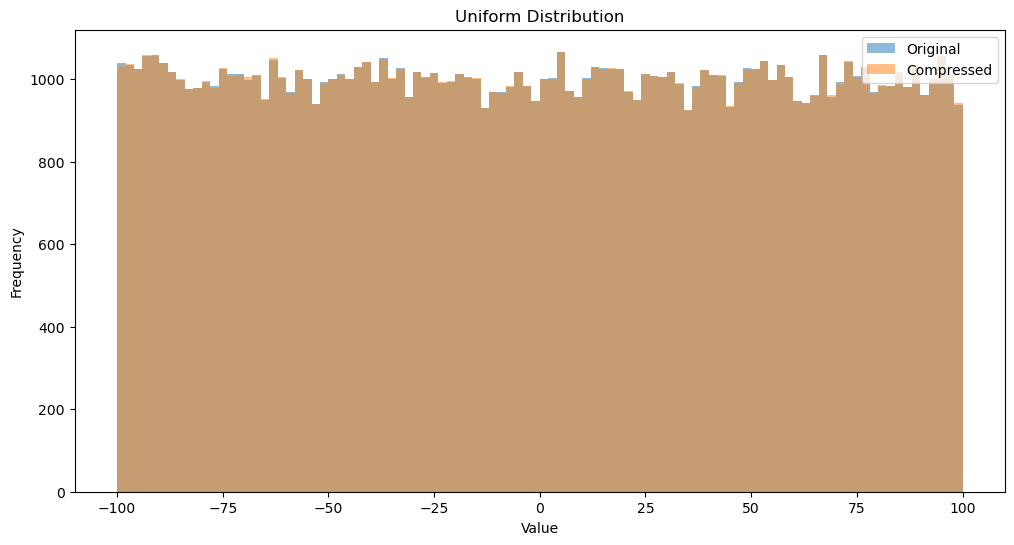

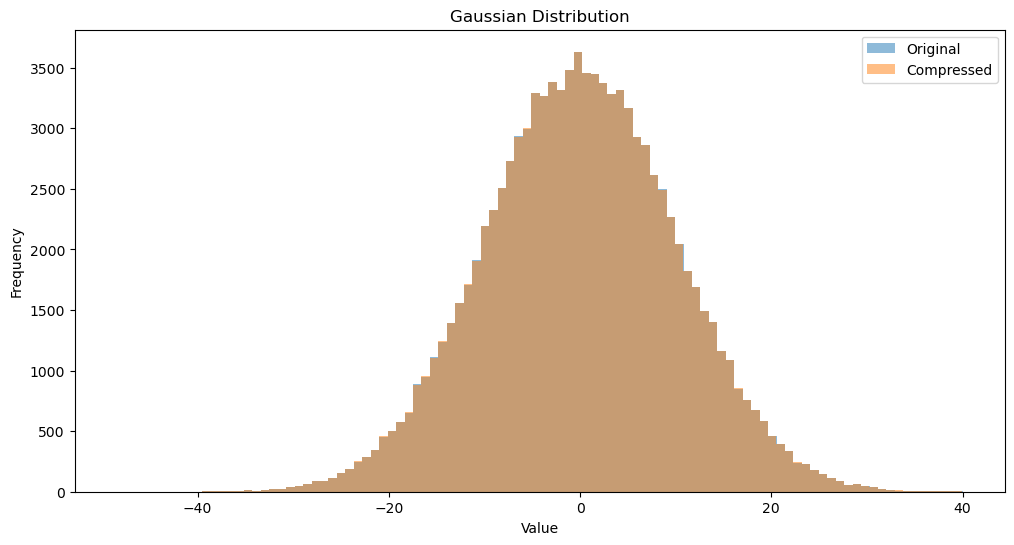

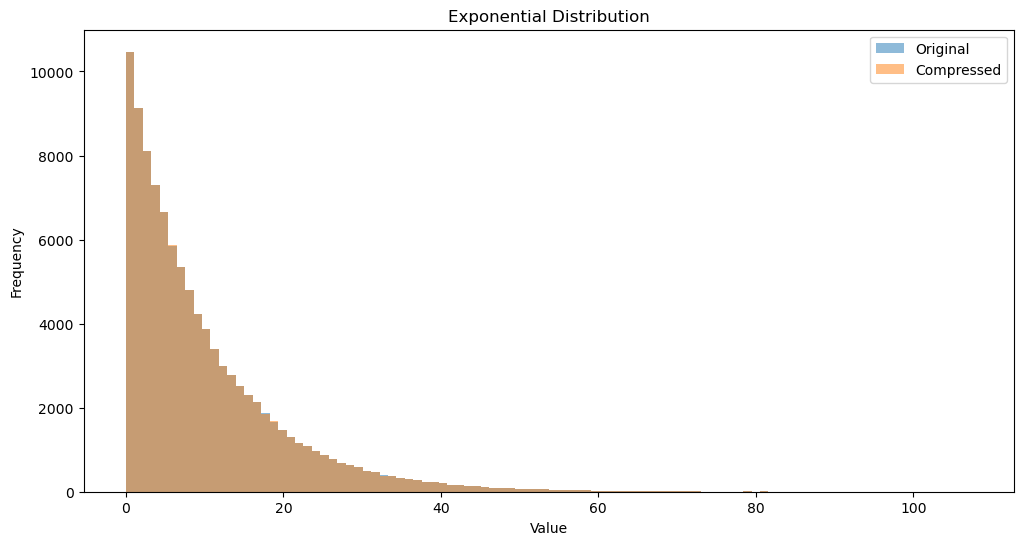

In [24]:
import numpy as np
import struct
import os
import matplotlib.pyplot as plt

# Generate samples from uniform, Gaussian, and exponential distributions
def generate_distributions(n_samples=100000):
    uniform = np.random.uniform(-100, 100, n_samples)
    gaussian = np.random.normal(0, 10, n_samples)
    exponential = np.random.exponential(10, n_samples)
    
    return {
        'uniform': uniform,
        'gaussian': gaussian,
        'exponential': exponential
    }

class FloatCompressor:

    # Total number of mantissa bits in IEEE 754 single precision 
    NMANTISSA = 23

    def __init__(self, mantissa_bits):
        self.mantissa_bits = mantissa_bits
        self.mantissa_bitmask = 0

        # Adjust the received bit number to some reasonable value:
        if self.mantissa_bits < 5:
            self.mantissa_bits = 5
        if self.mantissa_bits > self.NMANTISSA:
            self.mantissa_bits = self.NMANTISSA

        # Fill up the lower N bits
        for i in range(self.NMANTISSA - self.mantissa_bits):
            self.mantissa_bitmask |= (0x1 << i)
        # And now negate it to get the correct mask:
        self.mantissa_bitmask = ~self.mantissa_bitmask

        # Set the Magic numbers
        if self.mantissa_bits == self.NMANTISSA:
            self.rounding = 0
        else:
            self.rounding = 0x1 << (32 - (1 + 8 + self.mantissa_bits) - 1)

        self.vmax = 0x7f7 << 20
        self.vmax |= 0x000fffff ^ self.rounding

    def reduce_float_precision(self, value):
        
        # Check if any compression is to be made
        if self.mantissa_bits == self.NMANTISSA:
            return value

        # Check for NaN, etc
        if not np.isfinite(value):
            return value

        # Convert float to its 32-bit integer representation
        ivalue = np.float32(value).view(np.int32)

        # Safety-check if value (omitting the sign-bit) is lower than vmax (avoid overflow)
        if (ivalue & 0x7fffffff) < self.vmax:
            ivalue += self.rounding

        # Do the compression
        ivalue &= self.mantissa_bitmask

        # Convert the integer back to a float
        fvalue = ivalue.view(np.float32)
        return fvalue.item()  # Convert numpy float32 to Python float

def save_to_binary(data, filename):
    output_dir = 'output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Extract the base filename (in case the input contains a path)
    base_filename = os.path.basename(filename)
    
    # Construct the full file path
    file_path = os.path.join(output_dir, base_filename)
    
    # Save the data to the binary file
    data.astype('float32').tofile(file_path)
    
def get_file_size(filename):
    return os.path.getsize(filename)

def compare_statistics(original, compressed, name):
    print(f"\nStatistics for {name}:")
    print(f"Original Mean: {np.mean(original)}, Compressed Mean: {np.mean(compressed)}")
    print(f"Original Variance: {np.var(original)}, Compressed Variance: {np.var(compressed)}")
    print(f"Original Std Dev: {np.std(original)}, Compressed Std Dev: {np.std(compressed)}")

def compute_mse(original, compressed):
    return np.mean((original - compressed) ** 2)

def plot_distributions(original, compressed, name):
    plt.figure(figsize=(12, 6))
    plt.hist(original, bins=100, alpha=0.5, label='Original')
    plt.hist(compressed, bins=100, alpha=0.5, label='Compressed')
    plt.title(f'{name} Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Generate a relevantly large number of floating-point numbers from three distributions (e.g. uniform, Gaussian, and exponential).
data = generate_distributions()

#  Lossy compression function to zero out between 8 and 16 least significant bits of the mantissa.
compressor = FloatCompressor(mantissa_bits=12)  # Adjust mantissa_bits as needed
compressed_data = {
    'uniform': np.array([compressor.reduce_float_precision(x) for x in data['uniform']]),
    'gaussian': np.array([compressor.reduce_float_precision(x) for x in data['gaussian']]),
    'exponential': np.array([compressor.reduce_float_precision(x) for x in data['exponential']])
}

#  Save both full-precision and compressed data to binary files.
save_to_binary(data['uniform'], 'uniform_original.bin')
save_to_binary(data['gaussian'], 'gaussian_original.bin')
save_to_binary(data['exponential'], 'exponential_original.bin')

save_to_binary(compressed_data['uniform'], 'uniform_compressed.bin')
save_to_binary(compressed_data['gaussian'], 'gaussian_compressed.bin')
save_to_binary(compressed_data['exponential'], 'exponential_compressed.bin')

#  Measure and compare on-disk file sizes to analyze storage savings achieved through compression.
print(f"Uniform Original Size: {get_file_size('output/uniform_original.bin')} bytes")
print(f"Uniform Compressed Size: {get_file_size('output/uniform_compressed.bin')} bytes")
print(f"Gaussian Original Size: {get_file_size('output/gaussian_original.bin')} bytes")
print(f"Gaussian Compressed Size: {get_file_size('output/gaussian_compressed.bin')} bytes")
print(f"Exponential Original Size: {get_file_size('output/exponential_original.bin')} bytes")
print(f"Exponential Compressed Size: {get_file_size('output/exponential_compressed.bin')} bytes")

#  Compare statistical parameters of the distributions before and after compression.
compare_statistics(data['uniform'], compressed_data['uniform'], "Uniform")
compare_statistics(data['gaussian'], compressed_data['gaussian'], "Gaussian")
compare_statistics(data['exponential'], compressed_data['exponential'], "Exponential")

#  Compute Mean Squared Error between original and compressed data.
print(f"\nMSE for Uniform: {compute_mse(data['uniform'], compressed_data['uniform'])}")
print(f"MSE for Gaussian: {compute_mse(data['gaussian'], compressed_data['gaussian'])}")
print(f"MSE for Exponential: {compute_mse(data['exponential'], compressed_data['exponential'])}")

# Plot original and compressed data to observe distribution changes.
plot_distributions(data['uniform'], compressed_data['uniform'], "Uniform")
plot_distributions(data['gaussian'], compressed_data['gaussian'], "Gaussian")
plot_distributions(data['exponential'], compressed_data['exponential'], "Exponential")